In [136]:
import xarray as xr
import contextily as cx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles as cimgt
from matplotlib.patches import Patch

from shared import *
from make_rocky_beach import make_rocky_beaches

%matplotlib inline
%pdb off

print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now())
# Rule: SetNull(CoNED < MLLW | (CoNED > ZT & ElNino > ZT)

Automatic pdb calling has been turned OFF
(SL)  2024-06-04 11:14:12.490758


In [3]:
region  = 'South' 
use_s2  = False
path_wd = Path(os.getenv('dataroot')) / 'Sea_Level' / 'SFEI'
print ('Region:', region)

Region: South


In [4]:
BObj = CARIRegion(region, path_wd, use_s2)
gdf_rocky_coned = BObj.get_cari('rocky')
gdf_rocky_wgs = gdf_rocky_coned.to_crs(4326)

s2_ext = '_s2' if use_s2 else ''
path_log = BObj.path_wd / f'log_{BObj.region}_rocky_pct{s2_ext}.txt'

In [5]:
basemap_d = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/Elevation/World_Hillshade_Dark/MapServer/tile/{z}/{y}/{x}.jpg')
basemap   = cimgt.GoogleTiles(url='https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg')

cxbasemap   = cx.providers.Esri.WorldImagery
cxbasemap_d = cx.providers.CartoDB.DarkMatter
cxbasemap_t = cx.providers.USGS.USTopo

projp     = ccrs.PlateCarree()

dct_proju = {'Central': ccrs.UTM(10), 'North': ccrs.UTM(10), 'South': ccrs.UTM(11)}
proju     = dct_proju[region]

TFS = 20 # title
XFS = YFS = 16 # x/y axis
GFS = 14 # deg marks
CFS = 18 # colorbar labels
pt_parms = dict(verticalalignment='top', fontsize=20, color='w',
                bbox=dict(boxstyle='square,pad=0.05', facecolor='black'))

## setup plot parms and patch label outines
sty_cari   = dict(facecolor='none', edgecolor='deeppink') 
sty_coned  = dict(facecolor='none', edgecolor='red', linestyle='--')

rect_coned = Patch(label='CoNED Tile', **sty_coned)
rect_beach = Patch(label='CARI Beach', **sty_cari)

point      = plt.Line2D([0], [0], marker='o', color='k', label='Beach', linestyle='none')
point_lost = plt.Line2D([0], [0], marker='o', color='k', label='Lost Beach', linestyle='none')

In [6]:
def buffer_poly(gser, buffx, buffy=None):
    buffy = buffx if buffy is None else buffy
    
    w, s, e, n = gser.total_bounds
    return w-buffx, s-buffy, e+buffx, n+buffy

# Check Results

## Single Test Run

In [31]:
TestObj = SetupProj(region, 'rocky', scen_test0, BObj.path_wd, use_s2)

In [132]:
scen_test0 = 'med_rsl2050'
scen_test = scen_test0.replace('_rsl', '')
da_dem_test, da_mllw0_test, da_mllw_slr_test, df_slr_test, poly_test = make_rocky_beaches(region, scen=scen_test0, use_s2=use_s2, test=True)

No rocky polygons within Southern_California_Topobathy_DEM_1m_A_06
No rocky polygons within Southern_California_Topobathy_DEM_1m_A_12
No rocky polygons within Southern_California_Topobathy_DEM_1m_H_10
No rocky polygons within Southern_California_Topobathy_DEM_1m_G_12
No rocky polygons within Southern_California_Topobathy_DEM_1m_F_04
No rocky polygons within Southern_California_Topobathy_DEM_1m_D_14
No rocky polygons within Southern_California_Topobathy_DEM_1m_H_06
No rocky polygons within Southern_California_Topobathy_DEM_1m_H_07
No rocky polygons within Southern_California_Topobathy_DEM_1m_I_12
No rocky polygons within Southern_California_Topobathy_DEM_1m_G_02
30 rocky polygons within Southern_California_Topobathy_DEM_1m_C_08
Preparing DEM, MLLW, MHW took 0.47 min.
Southern_California_Topobathy_DEM_1m_C_08, polyix=833 cari id=80418: 
	Loss due to MLLW: 82.955 77.273. Lost: 5.682% 
	Loss due to Coned MHW: 61.364 68.182. Lost: -6.818% 
	Loss due to ENSO MHW: 68.182 74.432. Lost: -6.250%

In [139]:
scen_test0 = 'med_rsl2050'
scen_test = scen_test0.replace('_rsl', '')
da_dem_test, da_mllw0_test, da_mllw_slr_test, df_slr_test, poly_test = make_rocky_beaches(region, scen=scen_test0, use_s2=use_s2, test=True)

No rocky polygons within Southern_California_Topobathy_DEM_1m_A_06
No rocky polygons within Southern_California_Topobathy_DEM_1m_A_12
No rocky polygons within Southern_California_Topobathy_DEM_1m_H_10
No rocky polygons within Southern_California_Topobathy_DEM_1m_G_12
No rocky polygons within Southern_California_Topobathy_DEM_1m_F_04
No rocky polygons within Southern_California_Topobathy_DEM_1m_D_14
No rocky polygons within Southern_California_Topobathy_DEM_1m_H_06
No rocky polygons within Southern_California_Topobathy_DEM_1m_H_07
No rocky polygons within Southern_California_Topobathy_DEM_1m_I_12
No rocky polygons within Southern_California_Topobathy_DEM_1m_G_02
30 rocky polygons within Southern_California_Topobathy_DEM_1m_C_08
Preparing DEM, MLLW, MHW took 0.47 min.

	Loss due to MLLW: 82.955 77.273. Lost: 5.682% 
Southern_California_Topobathy_DEM_1m_C_08, polyix=833 cari id=80418: 
	Loss due to Coned MHW: 61.364 68.182. Lost: -6.818% 
	Loss due to ENSO MHW: 68.182 74.432. Lost: -6.250

In [43]:
df_slr_test

,y,x,MLLW,med_rsl2050,poly_ix,MHW,med_rsl2050_MHW
0,3766991.5,340717.5,1.0,0.0,833,1.0,1.0
1,3766991.5,340718.5,1.0,1.0,833,1.0,1.0
2,3766991.5,340719.5,1.0,1.0,833,1.0,1.0
3,3766991.5,340720.5,1.0,0.0,833,1.0,1.0
4,3766991.5,340721.5,0.0,0.0,833,1.0,1.0
...,...,...,...,...,...,...,...
171,3766977.5,340718.5,0.0,0.0,833,1.0,1.0
172,3766977.5,340719.5,0.0,0.0,833,1.0,1.0
173,3766977.5,340720.5,0.0,0.0,833,1.0,1.0
174,3766977.5,340721.5,0.0,0.0,833,1.0,1.0


In [ ]:
path_mhw = BObj.path_wd / 'JPL_Share' / 'MHW_NAVD88m_IDW.tif'
da_mhw = xrr.open_rasterio(path_mhw)
da_mhw_re = da_mhw.sel(band=1).rio.reproject(TestObj.epsg)
da_mhw_re = da_mhw_re.where(da_mhw_re < 1e20, np.nan)
da_mhw_re.rio.write_nodata(da_mhw_re.rio.nodata, encoded=True, inplace=True)

qm = da_mhw_re.plot()
cx.add_basemap(ax=qm.axes, crs=da_mhw.rio.crs, source=cxbasemap, attribution=False, zoom=7)

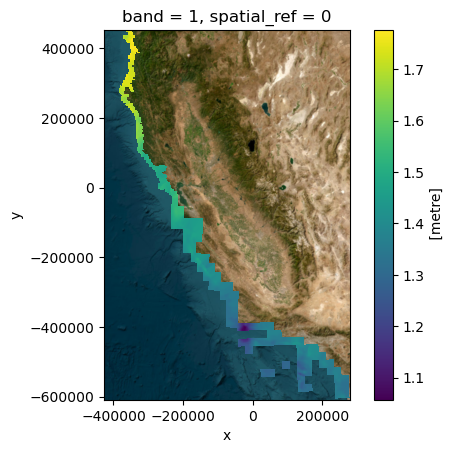

In [72]:
# get the enso dem file that contains this polygon
gdf_enso_map = get_enso_map(BObj.epsg) # enso dem path and its bounds
gdf_enso_map_poly = gdf_enso_map[gdf_enso_map.contains(poly_test)]
if gdf_enso_map_poly.empty:
    print (f'No ENSO dem contains polygon: {poly_test}') # add poly ix and cari id
    # continue
elif gdf_enso_map_poly.shape[0]>1:
    print (f'More than one ENSO dem contains polygon: {poly_test}, skipping for now') # add poly ix and cari id
    # continue

da_enso_dem = xrr.open_rasterio(gdf_enso_map_poly['path'].item())
da_enso_dem
# cut out the polygon

<xarray.DataArray (band: 1, y: 3000, x: 3000)> Size: 36MB
[9000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 24kB 3.405e+05 3.405e+05 ... 3.42e+05 3.42e+05
  * y            (y) float64 24kB 3.768e+06 3.768e+06 ... 3.767e+06 3.767e+06
    spatial_ref  int64 8B 0
Attributes: (12/18)
    AREA_OR_POINT:           Area
    DataType:                Generic
    LAYER_TYPE:              athematic
    SourceBandIndex:         0
    STATISTICS_COVARIANCES:  617.3098260517627
    STATISTICS_MAXIMUM:      105.04472351074
    ...                      ...
    STATISTICS_STDDEV:       24.845720477615
    _FillValue:              -3.402823e+38
    scale_factor:            1.0
    add_offset:              0.0
    long_name:               Layer_1
    units:                   metre